# Freeletics: Senior Data Analyst Case
Ravi Dayabhai

In [1]:
### Import dependencies
from random import random
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters
from operator import itemgetter

register_matplotlib_converters()

## Problem: TV Ad Attribution

The [simplified] problem we're faced with is trying to divine which "organic" registrations are _truely_ organic registrations versus those that are attributable to TV ads (of a particular variety in a particular market).

A "baseline + lift" model assumes that there is some natural rate of registrations (i.e., base rate) per interval of time and that the residual registrations in an interval are due to exposure to a TV ad. But the choice of interval duration ($m$) is not immediately obvious. In a world where we could run an experiment to estimate lift or where the signal was very evident, simple heuristics might work (e.g., observing the data, inferring the lift, and applying a decision rule based on our inference).

This notebook is a walk-through of my thinking and an attempt to use generated data (governed by known and established parameters) to illustrate the general process to distinguish lift from baseline registrations.

### Simplifying Assumptions

Before we proceed any further, it's worth noting that a number of simplifying assumptions are being made in the subsequent analysis, some of which are listed below:

- ignoring multichannel effects (e.g., watching TV doesn't result registering through another channel); only looking at direct effect in some time period after ad is run
- "last touch" attribution assumes away any 'halo effect' from running multiple ads 
- organic registration is strictly a dichotomy of TV vs. non-TV (i.e., there aren't other channels driving organic registrations)
- market/geo independence (e.g., TV ad in Germany doesn't cause registration in US)
- the distribution of the ad effect, roughly, decays as time passes with the most number of registrations clustering near the ad runtime
- we treat the ad effect _time_ is the same for ads of different type (read: the lift may be substantially different for one type of ad versus another)

Without structural knowledge of the underlying data or the ability to do any exploratory data analysis, which would likely consume at least half (if not more!) of the analysis process, this notion of a "baseline + lift" inspired an exploration of multiple regression on the time series of regressions.

**Important Note**: The simulated data set below picks up the algorithm after data pre-processing, namely:

- Partitioning the data by geography/market from registrations table (i.e., simulated data is for _one_ market)
- Filtering out `is_organic = False` registrations from registrations table
- Converting all date & time information to common timezone datetimes (e.g., UTC) in the ads table


### General Approach

Given that we're trying to tease apart some natural base rate registrations in a given year versus the lift due to running a television advertisement, I want to see if a very simple model in a very simple scenario is able to do this -- I explore this in the subsequent section, but wanted to lay out my general approach here first:

- For a given market, define $\hat{y}_{t}$ as expected total registrations in time interval $t$ where the interval is length $m$ minutes (read: this is the “meta” parameter). Therefore, if I [arbitrarily] choose $m$ to be 1 day, then there will be 365 $t$s (because I broke up the entire year by day). $x$ is a binary variable (on each ad) that is $1$ when the ad is run in that interval$^1$ _t_ and $0$ otherwise.

- For every choice of reasonable $m$ (EDA can give us a sense of what’s reasonable), the model is given by: 

$$\hat{y}_t = \beta_0 + \beta_1 x_t, \quad x_t = \begin{cases} 1\;\text{if }t\text{ contains ad exposure}\\ 0\; \text{if not}\end{cases}$$ 

...where $\beta_0$ is the base rate (assumed the same for all $t$ in the given year, 2018) and $\beta_1$ is the lift. The units for both are the number of registrations in the interval defined by $m$.

- Linear regression via OLS for any particular choice of $m$ results in the best fit estimate for $\beta_0$ and $\beta_1$. Record the $R^2$ for given $m$ and repeat for different choices of $m$. The meta parameter $m$ that result in the best $R^2$ yields is a good estimator for the ad’s shelf life; call that $m^*$.


- Count all registrations above $\beta_0$ (the base rate of registration per interval $t$) $m^*$ minutes after the ad ran as lift.


- Proceed with calculating the cost-per-registration (CPR) from TV by dividing total cost of an ad by its associated lift parameter.


**Generalization**: To generalize, we can add more terms to the model corresponding to each ad variant in a particular market:

$$
\hat{Y} = \beta X
$$

A **multiple regression model** is useful for this because we can directly interpret the coefficients as the quantity we are seeking to estimate. 

### Caveats & Considerations

#### "Strict" vs." Generous" Assignment$^1$, annoying discontinuities

The outlined approach briefly touches on the definition of "ad exposure." I explored two ways to do this determination: "strict" and "generous" assignments. "Assignment" describes whether the binary encodings in $X_t$ for each interval $t$ get labelled as `1` or a `0`.

The **"strict" or non-"generous" assignment** is pretty straightforward: 

1. Once we've chosen $m$, we partition the registration data into $t$ intervals. The observed outcome $Y$ is the number of registrations in each bin.
2. $X^i_t = 1$ (read: "for ad type $i$, $X$ in interval $t$ equals 1") **only if** an ad of type $i$ runs in that interval, $t$. 

Depending on the $m$ chosen, the time intervals that enclose ad run times may or may not truly capture the extent of registrations due to the ad. In fact, it's likely to _under_-attribute registrations to lift (said another way, the _ex ante_ or _ex post_ intervals will tend to _over_-attribute registrations to the base rate. This phenomena is illustrated below:

[INSERT PICTURE](PICTURE URL)

The **"generous" assignment** takes a more registrant-focused stance. 

1. For each choice of $m$, we label each registrant as being exposed to a given ad if the registration happened within $m$ units of time since the ad ran. A given registrant is assigned only one ad according to "last touch," or the most recent ad to which a given registrant is most likely to have been exposed.
2. $X^i_t = 1$ **if** a registrant of that ad type ($i$) registered in that interval, $t$. 

[INSERT PICTURE](PICTURE URL)

## Creating Ad Worlds

I begin by laying the groundwork for modeling worlds where _organic_ registrations in a given market are due to only a base rate and lift from ads (possibly of varying types and frequencies).

The following variables are the parameters for this universe (modifications here changes all worlds):

In [2]:
### Parameters & variables
M = 60
BEG_YEAR_STR = '01.01.2018 00:00:00,00'
END_YEAR_STR = '31.12.2018 23:59:59,999999'
TIME_STR_FORMAT = '%d.%m.%Y %H:%M:%S,%f'
TOTAL_BASE_REG = int(1e6)

# Lift multiplier on base rates: e.g., ads drive LIFT_BR_MULT times registrations vs. base)
LIFT_BR_MULT = 10

## Datetime conversions
beg_year = datetime.datetime.strptime(BEG_YEAR_STR, TIME_STR_FORMAT)
end_year = datetime.datetime.strptime(END_YEAR_STR, TIME_STR_FORMAT)
M_dt = datetime.timedelta(minutes=M)

## The implied base rate (per interval size M)
IMPLIED_BASERATE = TOTAL_BASE_REG*60*M / (end_year-beg_year).total_seconds()
LIFT = int(LIFT_BR_MULT*IMPLIED_BASERATE)

### Global base rate registrations for each M-minute interval
BASERATE_DTS = (np.random.random(TOTAL_BASE_REG) * (end_year - beg_year)) + beg_year

### Our choices of m; used in assessing results and plotting
min_m_guess = 10
max_m_guess = 120
intv = 5

### How we assign 1 or 0 to x_t: strict or generous
GENEROUS_AD_TYPE_ENCODING = False

Below, I've created a handful of useful objects to help model various scenarios:

In [3]:
### Define an ad class so we can use it to simulate multiple ads
class TVad():
    
    def __init__(self, label, lift_amount=LIFT, M=M, times_to_run=1):
        self.label = label
        self.lift_amount = lift_amount
        self.M = M
        self.M_dt = datetime.timedelta(minutes=M)
        
        # Select times ad will run
        self.ad_runtimes = list((np.random.random(times_to_run) * (end_year - beg_year)) + beg_year)
              
        # Generate the timestamps for registrations due to ad
        self.regs_due_to_ad = np.array([])
        for ad_runtime in self.ad_runtimes:
            lift_dts = (np.random.gamma(2, .08, lift_amount) * (M_dt)) + ad_runtime
            self.regs_due_to_ad = np.append(self.regs_due_to_ad, lift_dts)
        
    ## Getters
    def get_ad_effect_periods(self, m_guess):
        ends = [beg + datetime.timedelta(minutes=M) for beg in self.ad_runtimes]
        return list(zip(self.ad_runtimes, ends))
    
    def get_ad_runtimes(self):
        return self.ad_runtimes
        
    def get_label(self):
        return self.label
    
    def get_reg_times(self):
        return self.regs_due_to_ad


## HELPER FUNCTION: Sort ads by runtime
def ad_run_sorter(ads_ran, m_guess_int):
    '''
    Returns each ad instance in form: [((dt_beg, dt_end), label), ... ]
    '''
    all_ad_runs = []
    for ad in ads_ran:
        ad_runs = list(zip(ad.get_ad_effect_periods(m_guess_int), [ad.get_label() for _ in ads_ran]))
        all_ad_runs += ad_runs
    return sorted(all_ad_runs, key=lambda x: x[0][0])


### Takes registration dataframe as input and outputs one-hot encoded dataframe based on ad exposure
def reg_df_encoder(df, m_guess_int, ads_ran, generous_ad_type_encoding=False):
    
    ## Order the ads chronologically
    ordered_ad_runtimes = ad_run_sorter(ads_ran, m_guess_int)
    
    ## Workaround to ensure that the first & last bin is always represented even if no registration present
    # Create fake datum
    dummy_datum = dict(zip(df.columns, [0 for cols in df.columns]))
    dummy_datum['reg_time'] = beg_year
    dummy_datum2 = {**dummy_datum}
    dummy_datum2['reg_time'] = end_year
    
    ## Add fake datum
    df = df.append(pd.DataFrame([dummy_datum, dummy_datum2]), sort=False, ignore_index=True).sort_values('reg_time').reset_index(drop=True)
    
    
    ## If the encoding is generous do one hot encoding and cut by intervals...
    if generous_ad_type_encoding:
        '''
        Encoded interval in cleaned df will yield 1 (positive exposure) for an ad
        whenever interval contains ANY exposed registrations to said ad. 
        '''
        ## HELPER FUNCTION: Assigns registration to ad instance
        def ad_type_encoder_generous(x, chron_ads):
            ## Find the appropriate ad
            try:
                # Get the closest ad
                relevant_ad = max([ad_i for ad_i in chron_ads if x > ad_i[0][0]], key = itemgetter(0,0))
                # Return that ad string if within the estimated ad effect time, m
                if (x > relevant_ad[0][0]) and (x <= relevant_ad[0][1]):
                    return relevant_ad[1]
                else:
                    return np.nan
            except ValueError:
                return np.nan  
    
        ## Label the dataframe accordingly
        df['ad_exposure'] = df['reg_time'].apply(ad_type_encoder_generous, args=(ordered_ad_runtimes,))

        ## Put the data frame back together after one-hot encoding, drop ad_exposure column
        df_dummies = pd.get_dummies(df['ad_exposure'])


        df_clean = pd.concat([df.drop(columns=['ad_exposure']), df_dummies], axis=1).sort_values('reg_time').reset_index().drop(columns=['index'])
        df_clean['Y'] = 1
        
        
        df_clean['t'] = pd.cut(df['reg_time'], pd.date_range(start=beg_year, end=end_year + datetime.timedelta(milliseconds=1), freq=str(m_guess_int)+'Min'), right=False)
        df_clean = df_clean.groupby('t').sum()

        return df_clean
    
    ### ...otherwise encode after cut and assign encoding for each ad if ad run in interval.
    else:
        '''
        Encoded interval in cleaned df will yield 1 (positive exposure) for an ad 
        ONLY if said ad runtime was in that interval.
        '''
        # Do cut and grouping on intervals first
        df['t'] = pd.cut(df['reg_time'], pd.date_range(start=beg_year, end=end_year + datetime.timedelta(milliseconds=1), freq=str(m_guess_int)+'Min'), right=False)
        df['Y'] = 1
        df = df.groupby('t').sum()
         
        # Build lookup table for apply function on interval column
        keys = [ad.get_label () for ad in ads_run]
        values = []
        for k in keys:
            v = [ad[0][0] for ad in ordered_ad_runtimes if k == ad[1]]
            values.append(v)

        ad_run_lookup = dict(zip(keys, values))

        # Apply lookup function for each ad type
        def ad_type_encoder_strict(x, ad_runtimes):
            for ad_runtime in ad_runtimes:
                if ad_runtime in x:
                    return 1
            return 0
                
        df = df.reset_index()
        for ad_type, ad_runtimes in ad_run_lookup.items():
            df[ad_type] = df['t'].apply(ad_type_encoder_strict, args=(ad_runtimes,))   
        
        return df.set_index('t')
        
        
### Model fitting and evaluation function
def multi_ad_model_fitter(df, m_guess_int, ads_ran, generous_ad_type_encoding=False):
    m_guess = datetime.timedelta(minutes = m_guess_int)
    df = reg_df_encoder(df, m_guess_int, ads_ran, generous_ad_type_encoding)
    
    ## Normalize ad columns and split effect and response data for model fitting
    X = df[[col for col in df.columns if col != 'Y']].apply(lambda s: 1*(s>0))
    Y = df['Y']

    ### Fit & return linear regression model
    model = LinearRegression()
    model.fit(X, Y)
    return model, model.score(X.to_numpy(), Y.to_numpy()), X, Y


### Function to yield plots, results dataframe, and actual input & output dataframes
def plot_results(df, ads_ran):
    '''
    Returns results dataframe and plots different choices of m against r-squared for OLS models.
    '''
    results = []
    for m_guess in range(min_m_guess, max_m_guess+1, intv):
        model, score, X, Y = multi_ad_model_fitter(df, m_guess, ads_ran, GENEROUS_AD_TYPE_ENCODING)
        results.append([m_guess, score, model.intercept_, dict(zip(X.columns, model.coef_))])

    ## Put results into dataframe
    results_df_coefs = pd.DataFrame([trial.pop() for trial in results])
    results_df_others = pd.DataFrame(results, columns=['m_guess', 'r-sq', 'base_rate'])                   
    results_df = results_df_others.join(results_df_coefs)

    ## Plot
    plt.plot(results_df['m_guess'], results_df['r-sq'])

    # Red dashed line for actual ad effect time, M
    plt.axvline(x=M, color='r', linestyle='--')
    plt.show()

    return results_df, X, Y

## Single Ad World, a toy example
The code below attempts to simulate a world where only one advertisement is run throughout the year. We know the ad effective time and the associated lift to be expected from the ad. We begin by seeing if a **simple linear model** for chosen approximations of the ad effective time (when selected on the basis of $R^2$ values) does a good job of determining the true ad effective time.

### Simulating registrations

I build the _organic_ registration table for this _single_ market. Here (and in other worlds explored below) I'm assuming that the shape of the distribution governing the lift isn't uniform, but that the base rate of registrations throughout the year is.

In [4]:
### Create original ad
## New ad only airs multiple times
ad_1 = TVad('ad_1')

## Reduce to one list of registration times
ads_run = [ad_1]
all_dts = [BASERATE_DTS] + [ad_x.get_reg_times() for ad_x in ads_run]

### Put base registration and lift registration timestamps into dataframe
df1 = pd.DataFrame(np.concatenate(all_dts), columns=['reg_time']).astype("datetime64")

The uniform distribution over the year from which registrations were drawn results in the following base rate (per period size $M$):

In [5]:
int(IMPLIED_BASERATE)

114

The lift we should expect is:

In [6]:
LIFT

1141

Let's take a look at our simulated data in "Single Ad World."

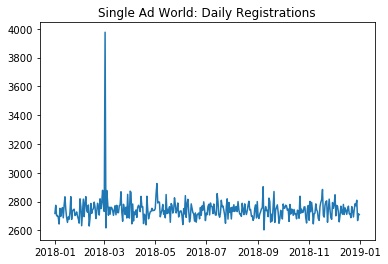

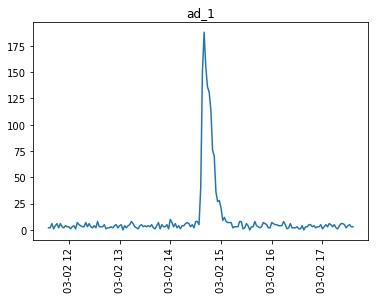

In [7]:
### Resampling 

## ...by day to make the plot easier to read
df1['dummy'] = 1
reg_per_day = df1.set_index('reg_time').resample('D').count()

### ...for intervals around ad runtime, every two mins.
ad_runtime = ad_1.get_ad_runtimes()[0]
mask = (df1['reg_time'] > ad_runtime - 3*M_dt) & (df1['reg_time'] < ad_runtime + 3*M_dt)
regs_around_ad_runtime = df1[mask].set_index('reg_time').resample('2Min').count()

### Plot
plt.plot(reg_per_day)
plt.title('Single Ad World: Daily Registrations')
plt.show()
plt.plot(regs_around_ad_runtime)
plt.title(ad_1.get_label())
plt.xticks(rotation='vertical')
plt.show()

### Clean up
df1.drop(columns=['dummy'], inplace=True)

### Estimating $M$, the ad effect time, with $m$

As noted in the process outlined earlier on, now we can vary my choice of $m$, the estimator for the ad effective time $M$ to see if, despite the "smoothing" assumption inherent in the estimation of the ad effect time, the best $R^2$ score corresponds with the "best" estimate of $M$.

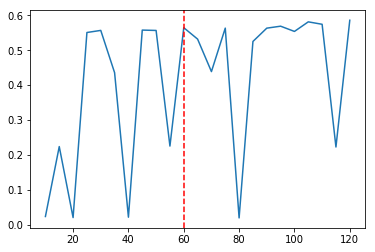

,m_guess,r-sq,base_rate,ad_1
22,120,0.586075,228.303722,1172.696278
19,105,0.581465,199.765987,1167.234013
20,110,0.574490,209.280092,1166.719908
17,95,0.569032,180.743446,1147.256554
10,60,0.564732,114.156981,1127.843019


In [8]:
results_df, X, Y = plot_results(df1, ads_run)
results_df.nlargest(5, 'r-sq')

We expect some noise due to discrete choices of $m$. This is due to the naïve assumption we made regarding which interval's expected registrations include the parameter estimate of lift (e.g.,  the ad runs in interval $t$, but interval $t$ does not capture the bulk of actual registrations due to lift).

This isn't too disappointing a result. This very, very simple model gets us into the ballpark of the "true" ad effect time $M$ pretty quickly (reading left to right). 

### Closing thoughts on Single Ad World

Initially, I thought that the configuration of the model (determined by the meta parameter) that yielded the highest $R^2$ would be a natural choice, but the variation due to the discrete choice of $m$ makes picking the "right" meta-parameter a little trickier.

While we're not guaranteed that the choice of $m$ (the estimate for $M$) corresponding to the maximal $R^2$ is the closest approximation to the "true" ad effect, we can rely on the assumption that the effect of an ad yields a decaying effect post-runtime. 

Thus, even if we choose a systematically undersized $m$ (say, by roughly choosing $m$ where gains to $R^2$ begins to level off per the plot above), we generally are comfortable with this "smoothing" because we can capture the bulk of the ad effect near the ad runtime. Importantly, the lift estimator $\beta_1$ is pretty good for these varying window sizes above a threshold as well, which makes the selection of a _perfect_ $m$ less important.

## Two Ad World, a toy-ish example

Let's introduce a second ad of a different type to see the impact on our model. First, some housekeeping to keep the code somewhat generalizable for later cases.

### Two Ad World v1.0
We start by constructing the first version of Two Ad World. For variety's sake, I assume that two ad types are run: the first is familiar (from Single Ad World) and the second is of a different variety (less effective) and run only once.

In [9]:
### Create new ad
ad_2 = TVad('ad_2', lift_amount=LIFT//2, times_to_run=1)

## Reduce to one list of registration times
ads_run = [ad_1, ad_2]
all_dts = [BASERATE_DTS] + [ad_x.get_reg_times() for ad_x in ads_run]

### Put base registration and lift registration timestamps into dataframe
df2 = pd.DataFrame(np.concatenate(all_dts), columns=['reg_time']).astype("datetime64")

We know _a priori_ what the total lift should be:

In [10]:
total_expected_lift_all_ads = np.concatenate([ad_x.get_reg_times() for ad_x in ads_run]).size
total_expected_lift_all_ads

1711

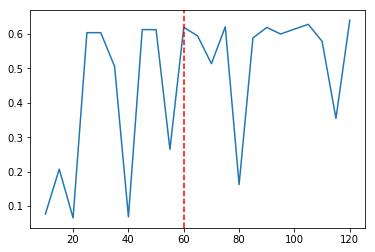

,m_guess,r-sq,base_rate,ad_1,ad_2
22,120,0.639053,228.299909,1172.700091,586.700091
19,105,0.627213,199.771937,1167.228063,540.228063
13,75,0.619926,142.695689,1124.304311,577.304311
10,60,0.618721,114.157570,1127.842430,564.842430
16,90,0.618099,171.237239,1121.762761,565.762761


In [11]:
results_df, X, Y = plot_results(df2, ads_run)
results_df.nlargest(5, 'r-sq')

It is interesting to compare the differences in the models also when run under different interval assignment mechanisms. The default has been the aforementioned "generous" encoding (i.e., any interval $t$ that has a registrant exposed to an ad (estimated by our choice of $m$) will yield $X_t$ = 1 for said ad type), but the results below show how the results differ when "strictly" (i.e., for interval $t$, $X_t$ = 1 for said ad type _only if_ an ad runtime is in that interval) encoding:

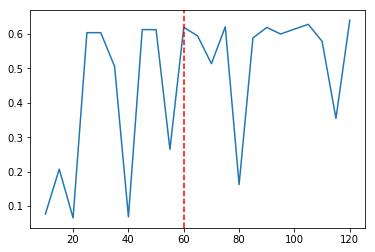

,m_guess,r-sq,base_rate,ad_1,ad_2
22,120,0.639053,228.299909,1172.700091,586.700091
19,105,0.627213,199.771937,1167.228063,540.228063
13,75,0.619926,142.695689,1124.304311,577.304311
10,60,0.618721,114.157570,1127.842430,564.842430
16,90,0.618099,171.237239,1121.762761,565.762761


In [12]:
### Toggle generous encoding OFF
GENEROUS_AD_TYPE_ENCODING = False

results_df, X, Y = plot_results(df2, ads_run)

### Toggle back to generous encoding
GENEROUS_AD_TYPE_ENCODING = True


results_df.nlargest(5, 'r-sq')

### Two Ad World, v2.0

Let's see if the model can begin to distinguish between ad effect sizes over multiple runs. 

We keep our two ad types (`ad_1`, `ad_2`), but now we run the second ad type multiple times throughout the year.

In [13]:
### Create new ad
ad_2 = TVad('ad_2', lift_amount=LIFT//2, times_to_run=4)

## Reduce to one list of registration times
ads_run = [ad_1, ad_2]
all_dts = [BASERATE_DTS] + [ad_x.get_reg_times() for ad_x in ads_run]

### Put base registration and lift registration timestamps into dataframe
df3 = pd.DataFrame(np.concatenate(all_dts), columns=['reg_time']).astype("datetime64")

We see here that we expect more lift (from the fact we're running the ad more times).

In [14]:
total_expected_lift_all_ads = np.concatenate([ad_x.get_reg_times() for ad_x in ads_run]).size
total_expected_lift_all_ads

3421

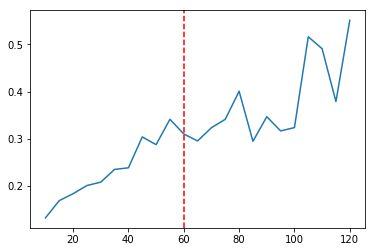

,m_guess,r-sq,base_rate,ad_1,ad_2
22,120,0.551343,228.570482,1172.429518,555.929518
19,105,0.516247,199.997001,1167.002999,374.669666
20,110,0.490898,209.519899,1166.480101,378.146767
14,80,0.400836,152.381054,581.118946,558.618946
21,115,0.378912,219.046221,578.953779,374.953779


In [15]:
results_df, X, Y = plot_results(df3, ads_run)
results_df.nlargest(5, 'r-sq')